In [10]:
# Run training/evaluation and plot a heatmap of ROC AUC
from timestepper import load_config, train_and_eval_all_timesteps
import matplotlib.pyplot as plt
import seaborn as sns

def metrics_to_grids(all_metrics, skip=('classification_report',)):
    """
    all_metrics: {train_t: {test_t: {metric_name: value, …}, …}, …}
    Returns: (train_ts, test_ts, grids) where
      train_ts: sorted list of train timesteps
      test_ts:  sorted list of test  timesteps
      grids:    dict metric_name -> 2D np.array of shape (len(train_ts),len(test_ts))
    Only scalar metrics are turned into heatmap grids.
    """
    import numpy as np

    train_ts = sorted(all_metrics.keys())
    test_ts  = sorted(next(iter(all_metrics.values())).keys())
    # pick one sample entry to discover scalar metrics
    sample   = next(iter(next(iter(all_metrics.values())).values()))

    # Only include metrics whose values are real numbers
    scalar_metrics = [
        k for k, v in sample.items()
        if k not in skip and isinstance(v, (int, float, np.floating, np.integer))
    ]

    grids = {
        m: np.zeros((len(train_ts), len(test_ts)), dtype=float)
        for m in scalar_metrics
    }

    for i, tr in enumerate(train_ts):
        for j, te in enumerate(test_ts):
            entry = all_metrics[tr][te]
            for m in scalar_metrics:
                val = entry.get(m, np.nan)
                grids[m][i, j] = float(val)

    return train_ts, test_ts, grids


In [12]:

# 1) Load config (pass your YAML path or use None for defaults)
config = load_config('config.yaml')  # or None

# 2) Run the full train‐and‐eval sweep
all_metrics, all_losses = train_and_eval_all_timesteps(config)


/home/red/dl-graph/timestepper.py:236: UserWarning: Error loading config from config.yaml: [Errno 2] No such file or directory: 'config.yaml'. Using default configuration.
  warnings.warn(f"Error loading config from {config_path}: {e}. Using default configuration.")


Configuration: {
  "model": {
    "hid_dim": 64,
    "num_layers": 3,
    "dropout": 0.0,
    "weight_decay": 0.0,
    "contamination": 0.1,
    "backbone": "gcn",
    "lr": 0.004,
    "epoch": 25,
    "gpu": 0,
    "batch_size": 8224,
    "num_neigh": 10,
    "weight": 0.5,
    "verbose": 2
  },
  "data": {
    "use_aggregated": false,
    "use_temporal": true,
    "local": true,
    "batch_size": 8224
  },
  "training": {
    "save_embeddings": true,
    "save_dir": "./saved_models"
  }
}

=== Training on timestep 1 ===
Epoch 0000: Loss 13136.2832 |  | Time 0.38
Epoch 0001: Loss 7805.0693 |  | Time 0.16
Epoch 0002: Loss 4681.2310 |  | Time 0.05
Epoch 0003: Loss 2770.4536 |  | Time 0.05
Epoch 0004: Loss 1667.2751 |  | Time 0.05
Epoch 0005: Loss 1141.9379 |  | Time 0.05
Epoch 0006: Loss 966.3049 |  | Time 0.05
Epoch 0007: Loss 952.6691 |  | Time 0.05
Epoch 0008: Loss 985.7990 |  | Time 0.05
Epoch 0009: Loss 1012.2688 |  | Time 0.05
Epoch 0010: Loss 1012.9655 |  | Time 0.05
Epoch 0011: 

KeyboardInterrupt: 

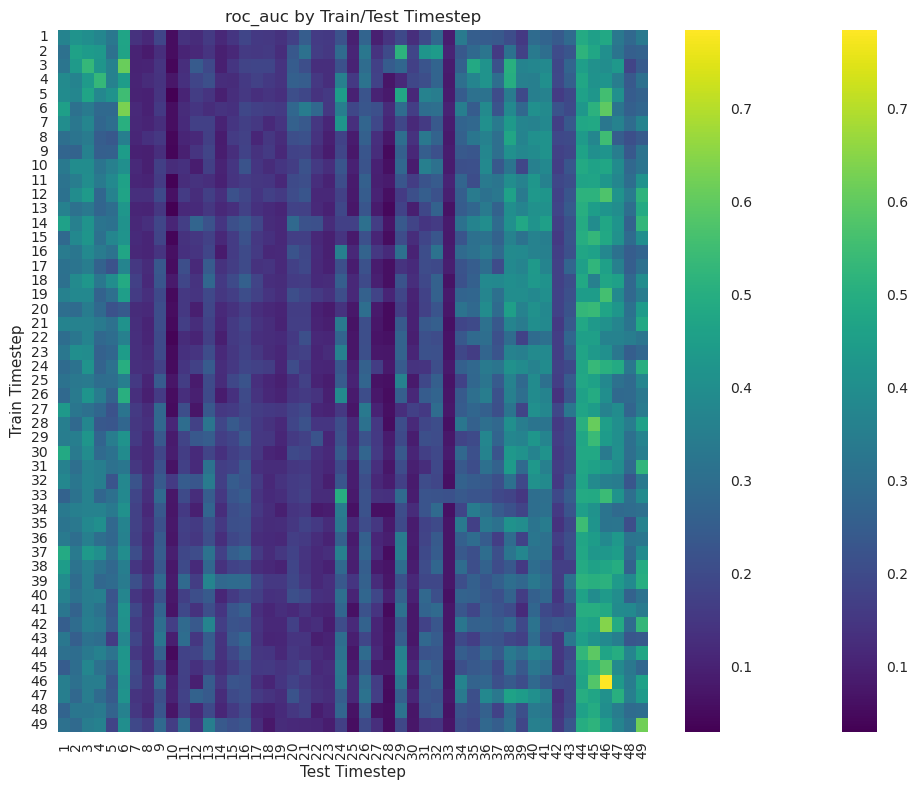

In [20]:
# unrolls the nested dicts into a grid
def plot(metrics, key='roc_auc'):
    train_ts, test_ts, grids = metrics_to_grids(all_metrics)

    # 4) Plot ROC AUC heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        grids[key][::-1],  # Reverse the data along the y-axis
        xticklabels=test_ts,
        yticklabels=train_ts[::-1],  # Reverse the y-axis labels
        cmap='viridis',
        annot=False
    )
    ax = sns.heatmap(
    grids[key],
    xticklabels=test_ts,
    yticklabels=train_ts,
    cmap='viridis',
    annot=False
)   
    ax.set_xlabel('Test Timestep')
    ax.set_ylabel('Train Timestep')
    ax.set_title(f'{key} by Train/Test Timestep')
    plt.tight_layout()
    plt.show()
plot(all_metrics, key='roc_auc')

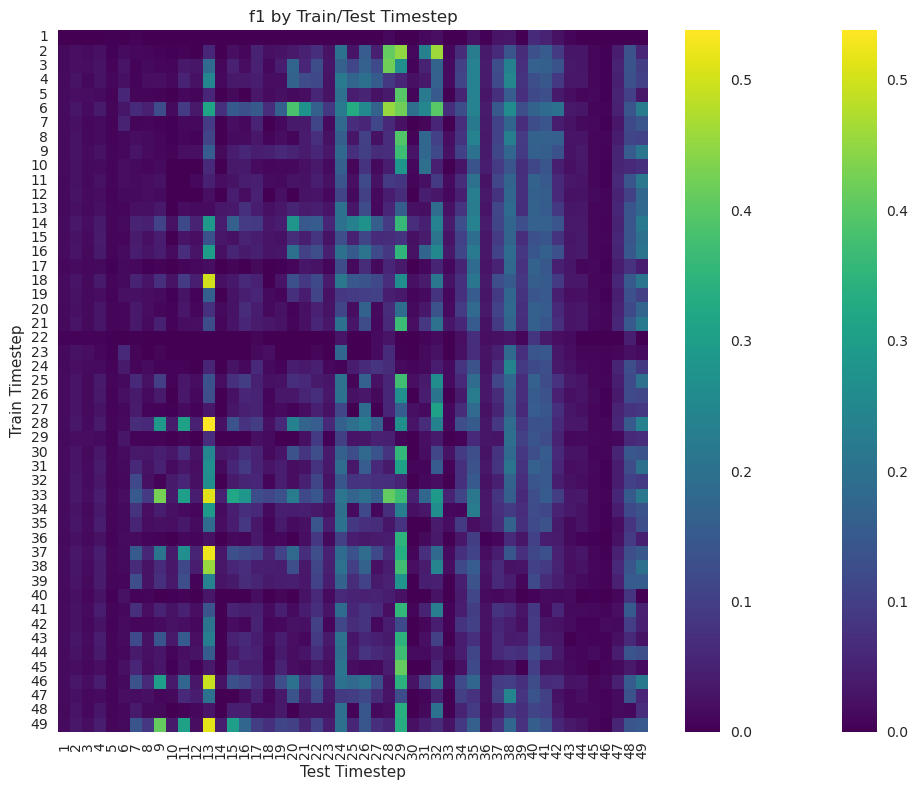

In [21]:
plot(all_metrics, key='f1')
